# Contents

1. Nea. ancestry trajectories for different genomic regions (simulated individually)
2. Working with the simulated VCF data - example of a whole exon simulation (70Mb)
3. Desert size vs amount of deleterious sequence (different genomic regions)

In [180]:
suppressPackageStartupMessages({
    library(VariantAnnotation)
    library(tidyverse)
    library(purrr)
})

## 1. Nea. ancestry trajectories for different genomic regions (simulated individually)

Shown is the case of additivity ($h = 0.5$) with the mutation rate $=1e-8$ per bp per generation. This is slightly higher than what Kelley and I simulated previously (which was $7e-9$, roughly the mutation rate of non-synonymous mutations).

Clearly the larger proportion of deleterious sequence, the higher the impact of the Neanderthal genetic load.

**Kelly simulated ~70Mb of exonic sequence and found that one needs ~10% admixture rate so that ~2-3% of Nea. ancestry survives** over time. 

However, we found using logistic regression analysis and analysis of distributions of Nea. ancestry that not only protein coding regions, but also promoters and other non-coding sequence shows signs of negative selection against Nea. ancestry. **In fact, there is more than 200Mb sequence that seems to be under negative selection** against Nea. ancestry (compared to just 70 Mb considered by Kelley).

**If all of that sequence behaves additively or near-dominantly, Neanderthal ancestry would be completely wiped out by negative selection.**

Maybe this is another evidence for recessivity of some of those regions? At least in case of protein coding + TF binding sequence? This would make different regions "compete" - recessive sequence would be selected from Neanderthals, additive/dominant sequence would be selected against. **Maybe the 2% we see today is the result of tug of war between additive and recessive selection?**

I saw in my earlier simulations that a mixture of dominances leads to an equilibrium state between dominant and recessive extremes, depending on the ratio between $h=0.0$ and $h=1.0$.

In [2]:
df_h <- lapply(c("exon", "promoter", "protein_coding", "tf_binding_site", "utr3"), function(r) {
lapply("0.5", function(h) {
    files <- list.files(path="../data/simulations/", pattern=paste0(r, "_h_", h, "_rep_.*trajectory.*"), full.names=TRUE)
    lapply(files, function(f) {
        suppressMessages(read_tsv(f) %>% mutate(rep=f, h=paste("dominance =", h), reg=r))
    }) %>% bind_rows
}) %>%
    bind_rows %>% 
    group_by(h, gen, reg) %>% summarise(nea_mean=mean(mean), nea_sd=mean(sd)) %>%
    ungroup
}) %>% bind_rows

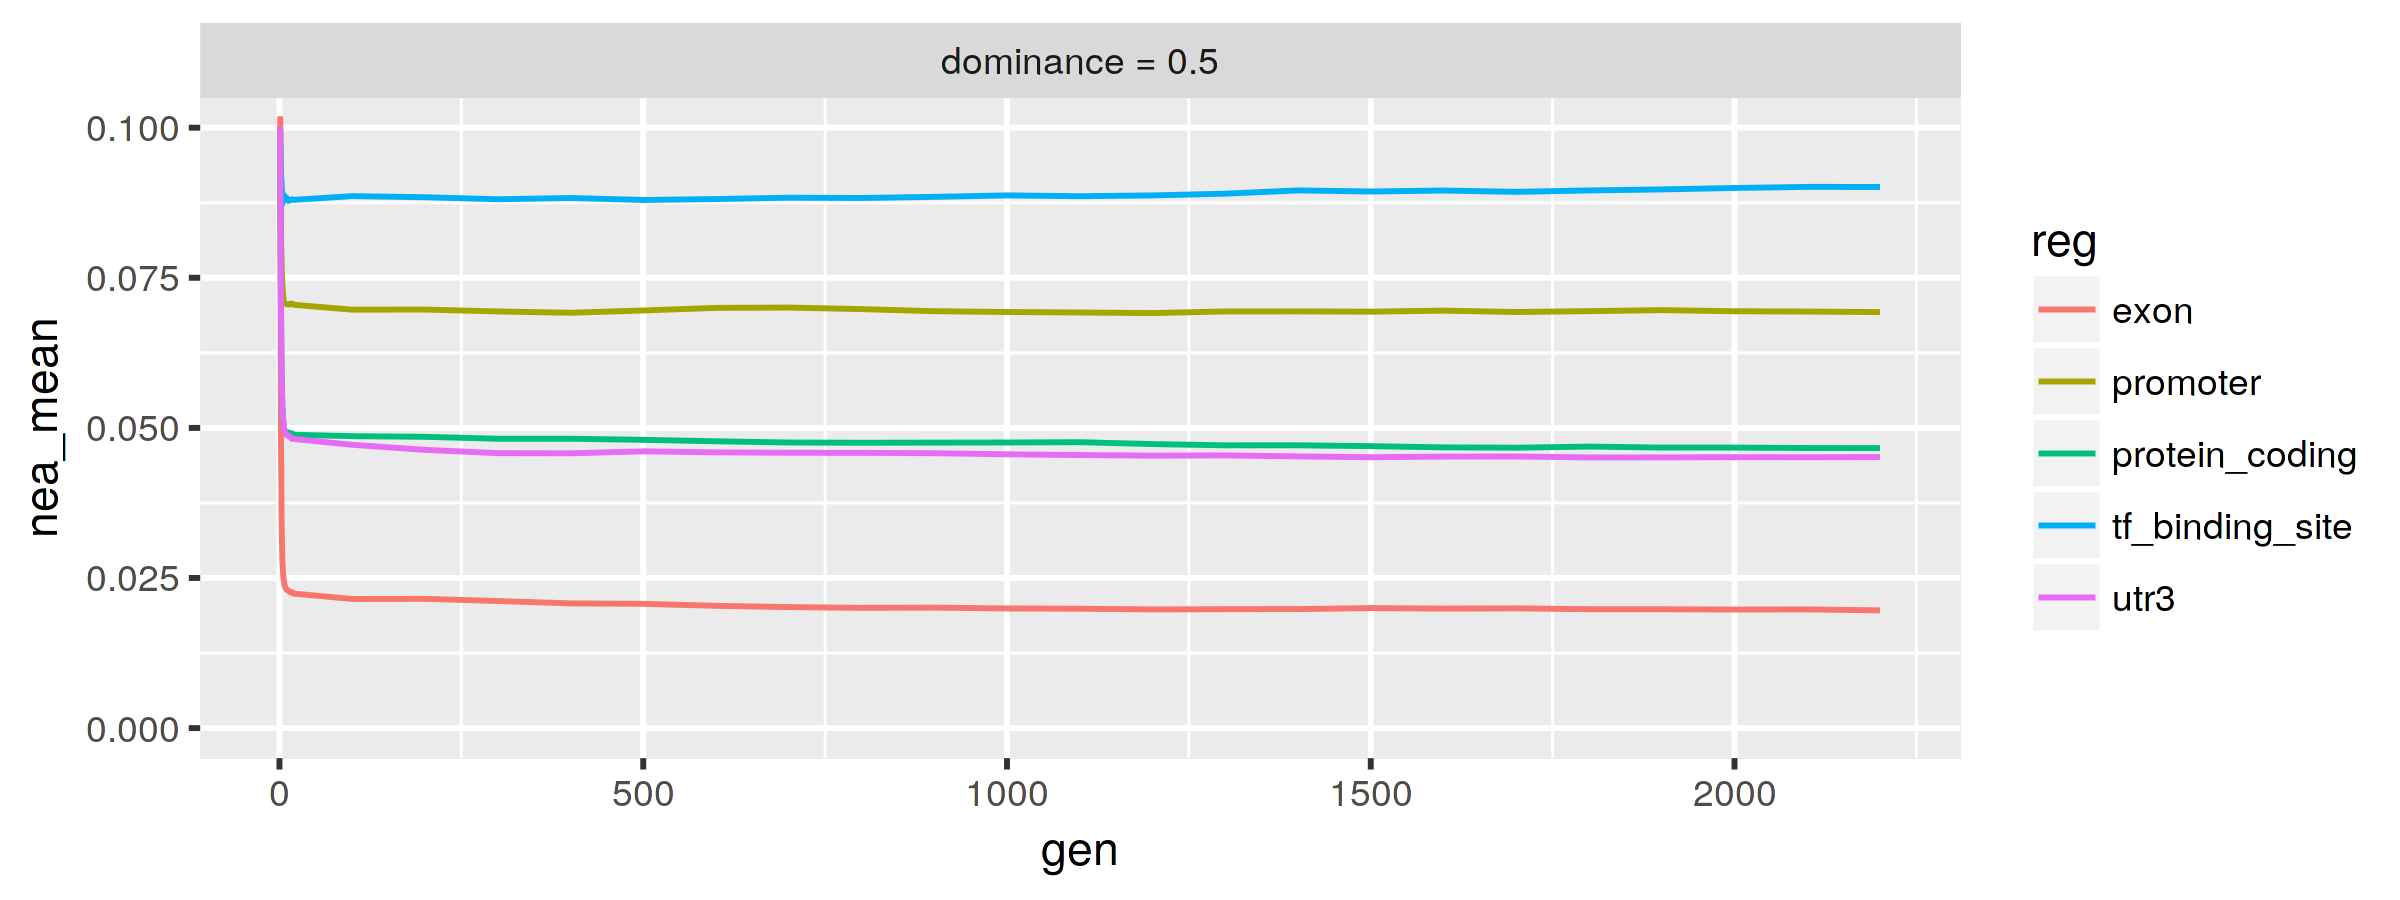

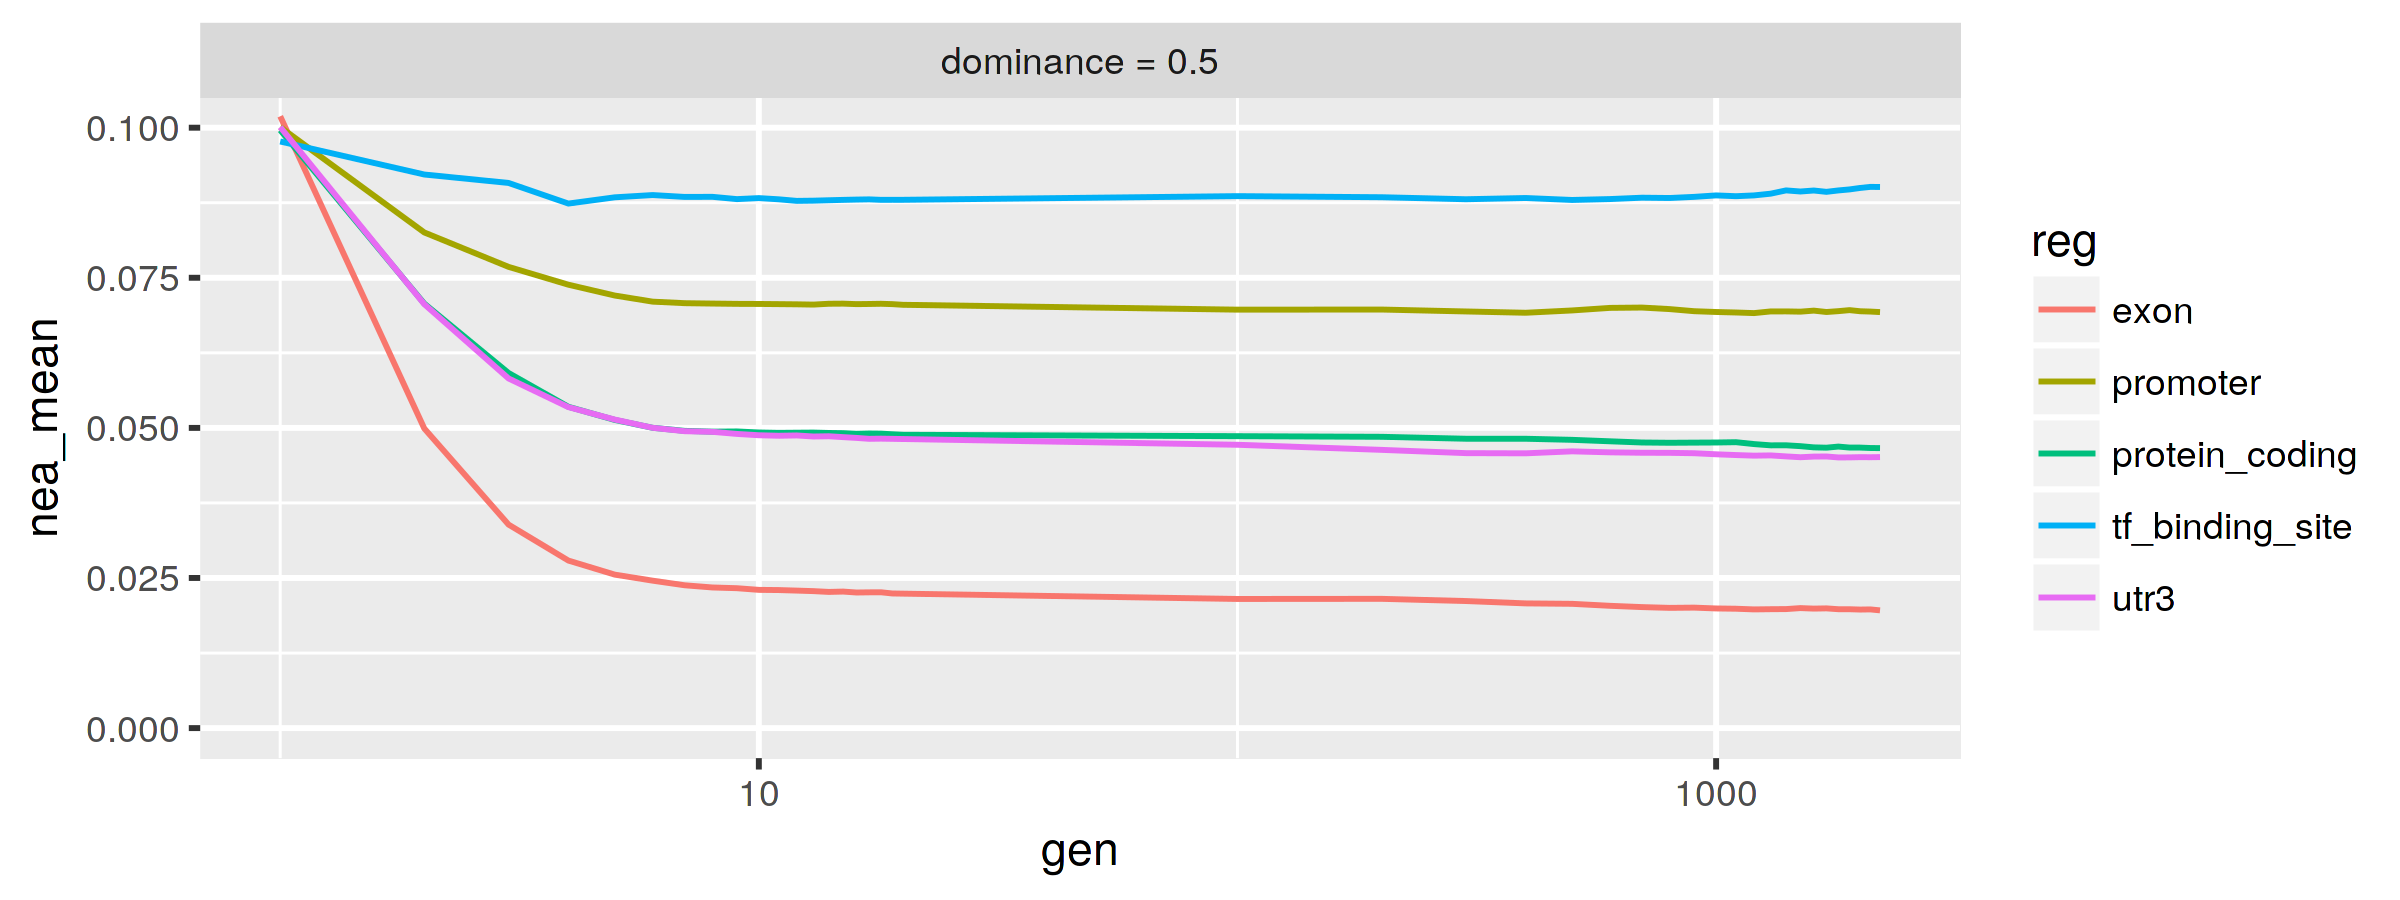

In [3]:
options(repr.plot.width=8, repr.plot.height=3, repr.plot.res=300)

ggplot(df_h, aes(gen, nea_mean)) + geom_line(aes(color=reg)) + facet_grid(. ~ h) + coord_cartesian(y=c(0, 0.1))
ggplot(df_h, aes(gen, nea_mean)) + geom_line(aes(color=reg)) + facet_grid(. ~ h) + coord_cartesian(y=c(0, 0.1)) + scale_x_log10()

## 2. Working with the simulated VCF data - example of a whole exon simulation (70Mb)

In [2]:
setwd("../")

**This script contains functions for processing and transforming VCFs simulated in SLiM**

Although only 2 functions are needed - `read_vcf` and `get_markers`.

In [200]:
source("code/process_slim_vcf.R")

VCFs generated from a simulation of each genomic region dumped at the end of each simulation (generation 2200).

The VCFs contains all mutations in the simulation - deleterious (MT=0 in the INFO field) and neutral markers (MT=1 in the info field).

In [201]:
list.files("data/simulations/", "*.vcf.gz")

[1] "exon_h_0.5_rep_1_gen_2200.vcf.gz"           
[2] "promoter_h_0.5_rep_1_gen_2200.vcf.gz"       
[3] "protein_coding_h_0.5_rep_1_gen_2200.vcf.gz" 
[4] "tf_binding_site_h_0.5_rep_1_gen_2200.vcf.gz"
[5] "utr3_h_0.5_rep_1_gen_2200.vcf.gz"

In [202]:
vcf <- read_vcf("data/simulations/exon_h_0.5_rep_1_gen_2200.vcf.gz")

Load the simulated neutral markers (MT=1), calculate their frequencies and transform their coordinates from the SLiM 0-based system into their original genomic positions:

In [241]:
markers <- get_markers(vcf=vcf, regions_bed="data/slim_coords/exon_all_sites.bed")

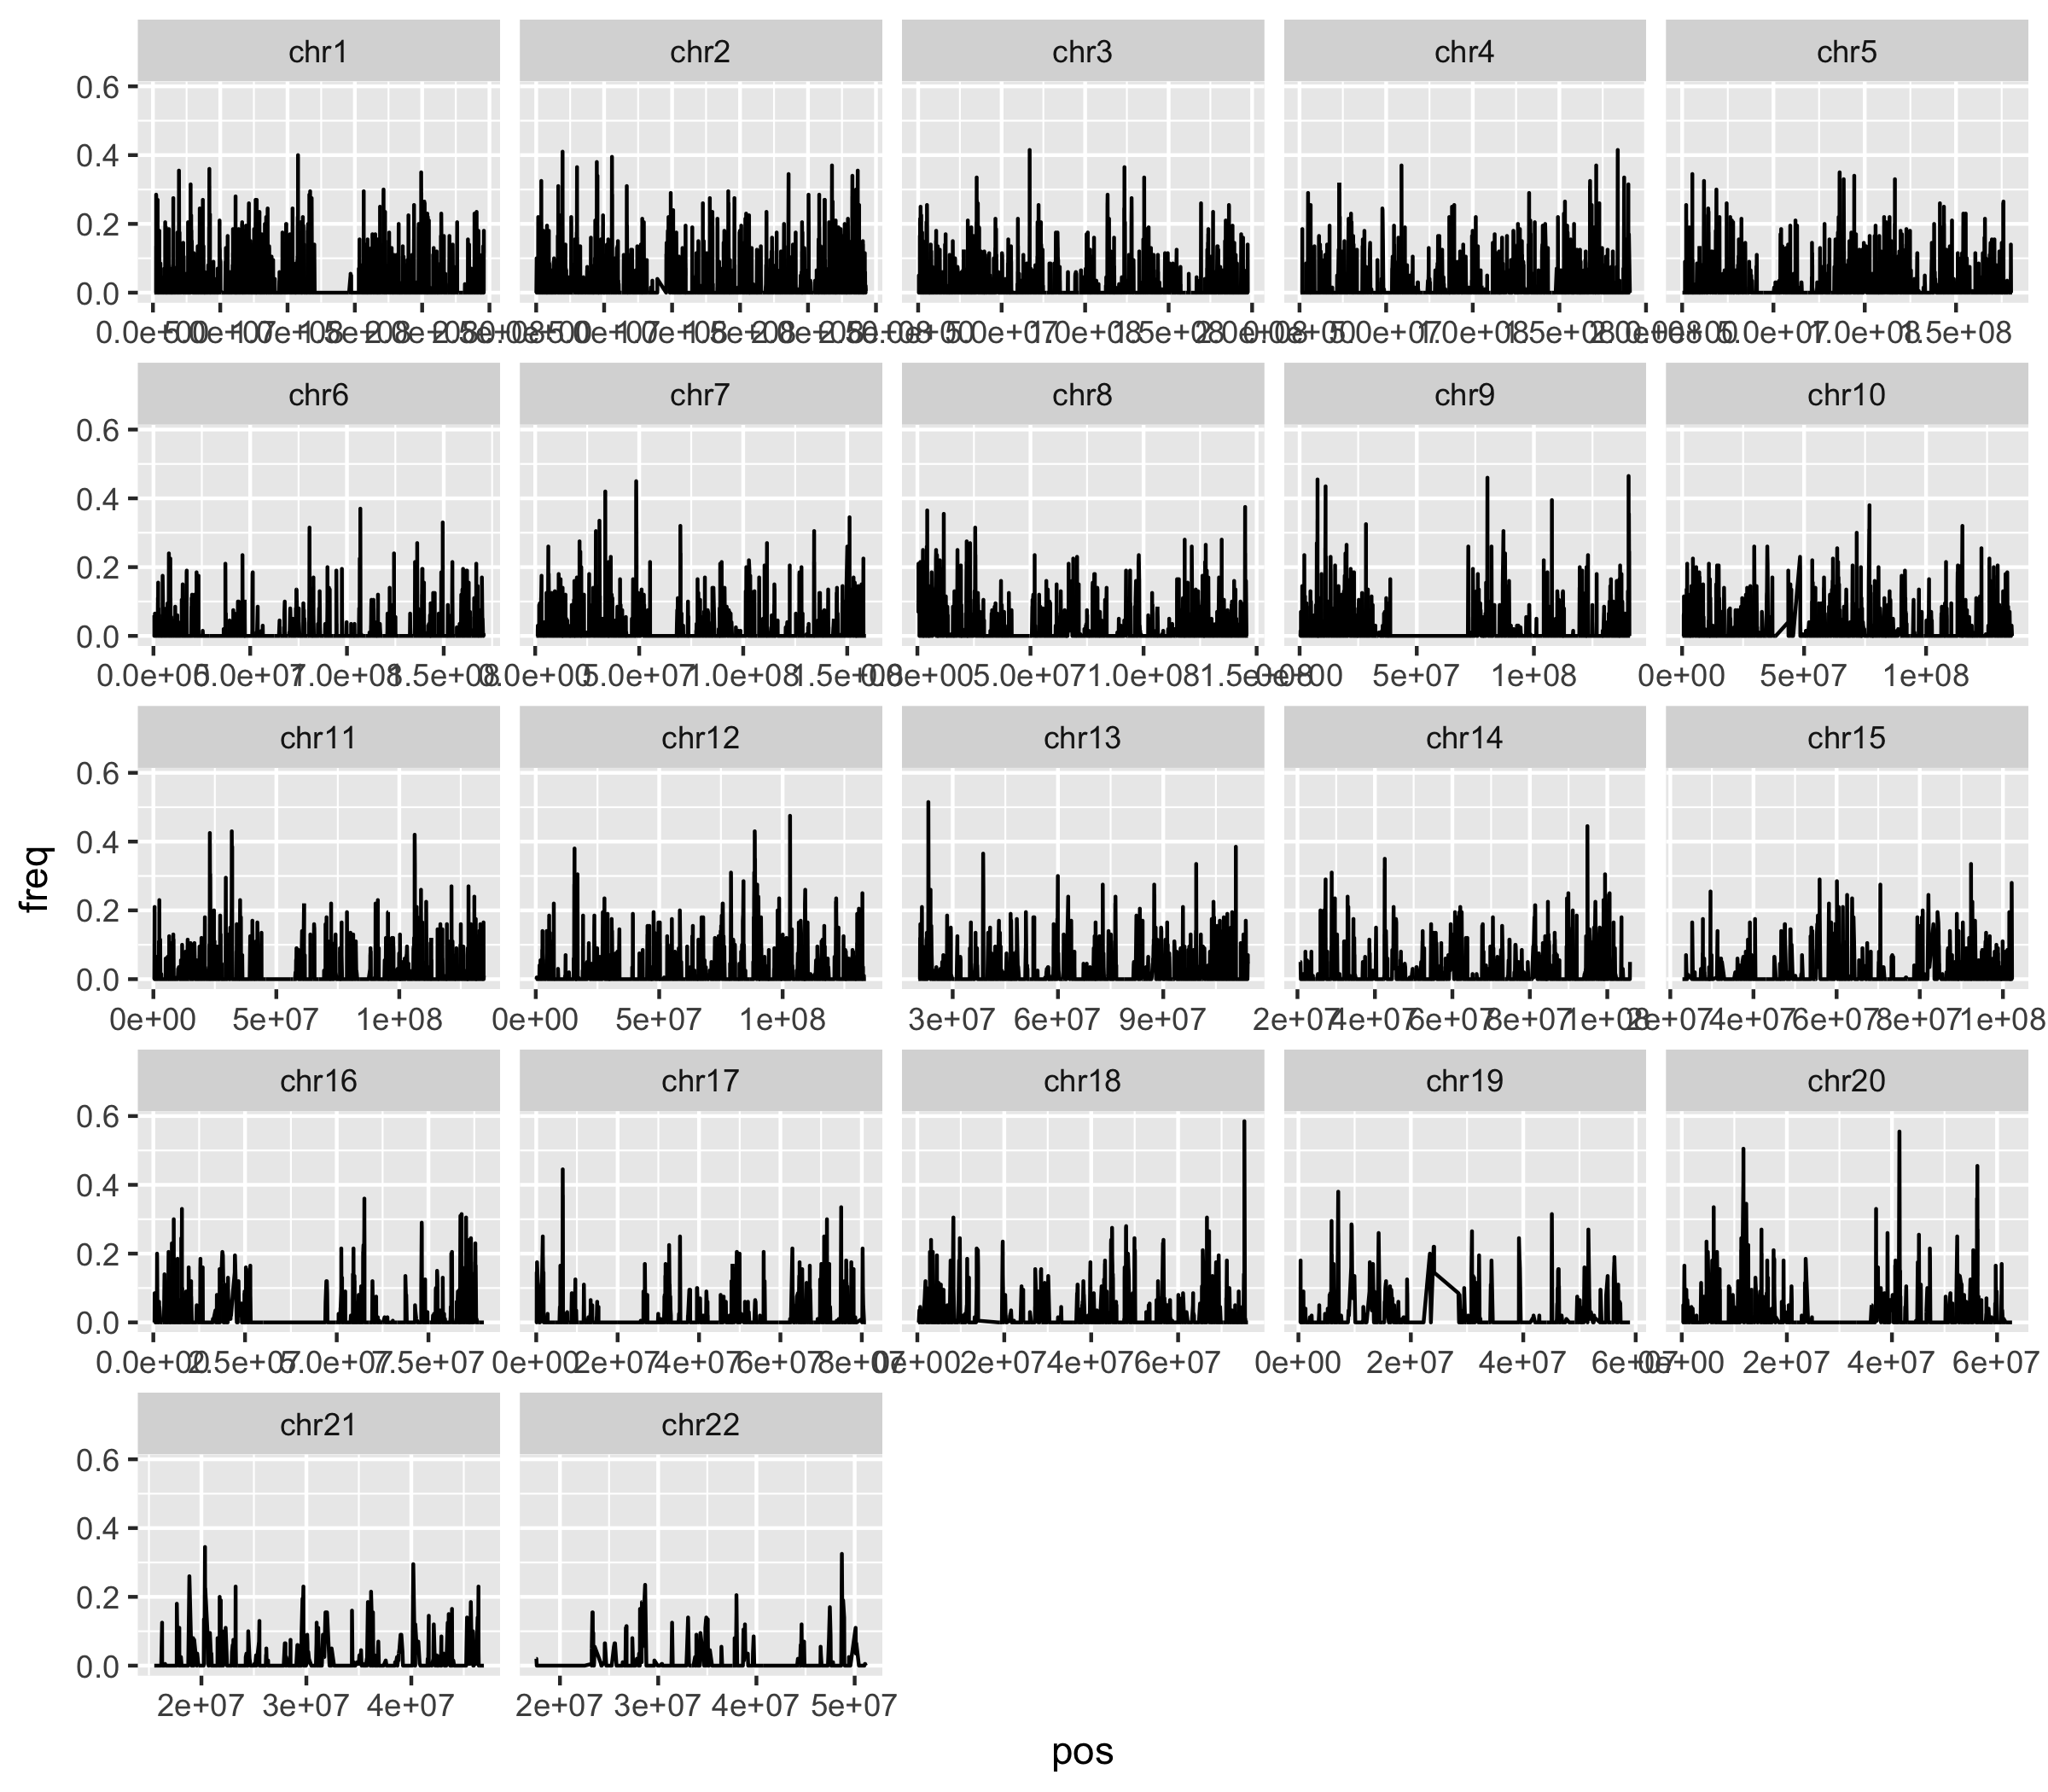

In [242]:
options(repr.plot.width=8, repr.plot.height=7, repr.plot.res=300)
ggplot(markers, aes(pos, freq)) + geom_line() + facet_wrap(~ chrom, scales="free_x")

Perform a run-length-encoding on the 0/1 states (1 being Nea. allele frequency frequency > 0). We are interested in runs of 0s.

In [243]:
desert_runs <- rle(as.integer(markers$freq > 0))

I'm too lazy to convert the runs of 0 frequency alleles back to real physical distance. So here I'm just assuming a fixed distance between each pair of neutral markers, based on the average distance in the real genome:

In [245]:
# total number of markers simulated (50k within gaps + X within the simulated genomic regions, exons in this case)
nrow(markers)

[1] 63073

In [246]:
(avg_dist <- 3e9 / nrow(markers))

[1] 47563.93

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


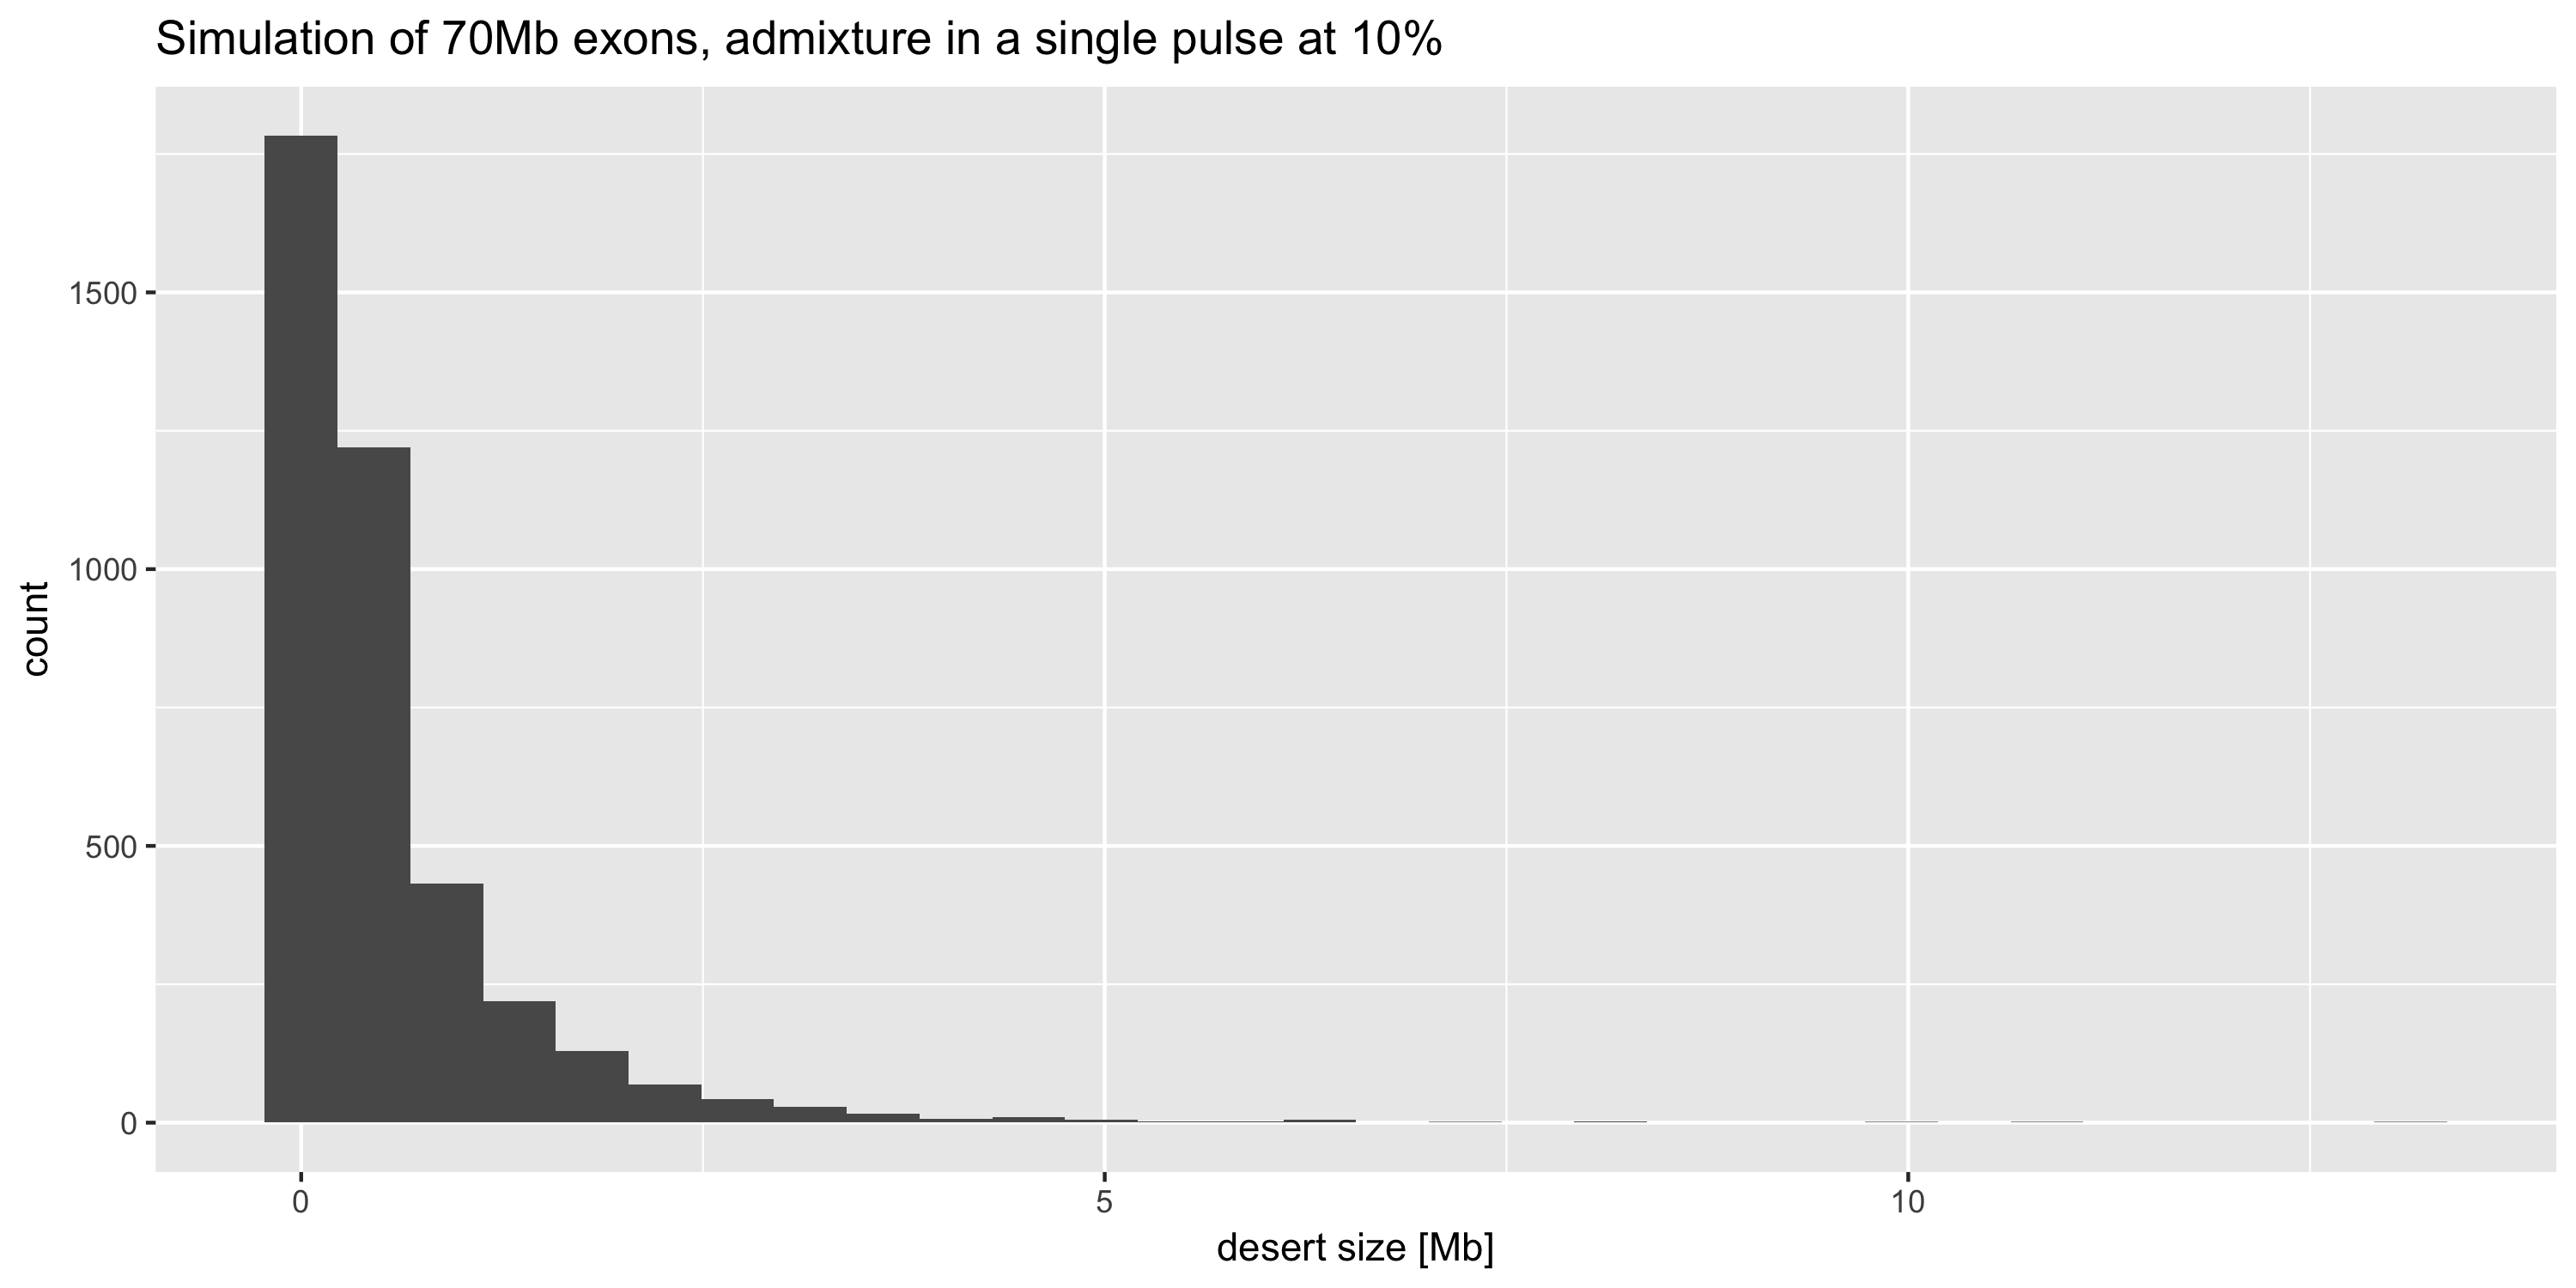

In [247]:
options(repr.plot.width=10, repr.plot.height=5)

qplot((desert_runs$lengths[desert_runs$values == 0] * avg_dist) / 1e6, xlab="desert size [Mb]",
      main="Simulation of 70Mb exons, admixture in a single pulse at 10%")

## 3. Desert size vs amount of deleterious sequence (different genomic regions)

In [195]:
regions <- c("exon", "promoter", "protein_coding", "tf_binding_site", "utr3")

In [248]:
desert_sizes <- map(regions, function(reg) {
    vcf <- read_vcf(paste0("data/simulations/", reg, "_h_0.5_rep_1_gen_2200.vcf.gz"))
    markers <- get_markers(vcf, paste0("data/slim_coords/", reg, "_all_sites.bed"))
    desert_runs <- rle(as.integer(markers$freq > 0))
    avg_dist <- 3e9 / nrow(markers)

    tibble(region=reg,
           desert_size=desert_runs$lengths[desert_runs$values == 0] * avg_dist / 1e6)
}) %>% bind_rows

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


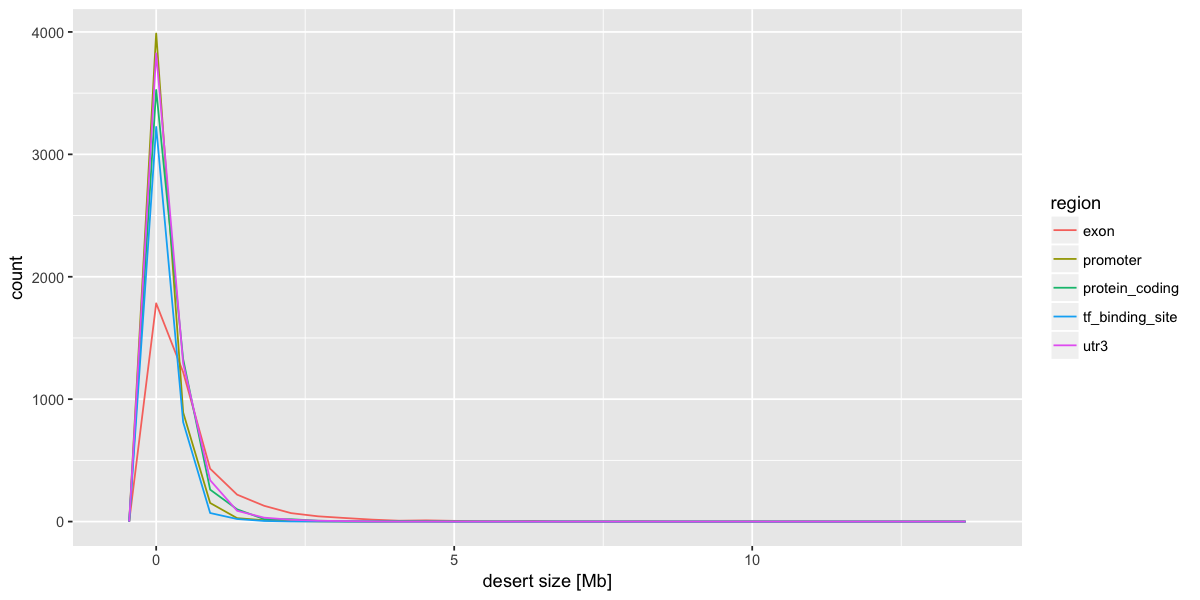

In [224]:
ggplot(desert_sizes, aes(desert_size, color=region)) + geom_freqpoly() + xlab("desert size [Mb]")

### Desert size summary stats for all regions

In [231]:
group_by(desert_sizes, region) %>% summarise(mean(desert_size),
                                             median(desert_size),
                                             min(desert_size),
                                             max(desert_size))

region,mean(desert_size),median(desert_size),min(desert_size),max(desert_size)
exon,0.5573226,0.2853836,0.04756393,13.175210
promoter,0.1845040,0.1087587,0.05437935,4.404727
protein_coding,0.2627430,0.1638359,0.05461198,6.717274
tf_binding_site,0.1570598,0.1148567,0.05742836,2.641704
utr3,0.2514390,0.1584507,0.05281690,3.644366
